# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Get Data

In [2]:
obesity_data = pd.read_csv('obesity_data.csv')
obesity_data.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


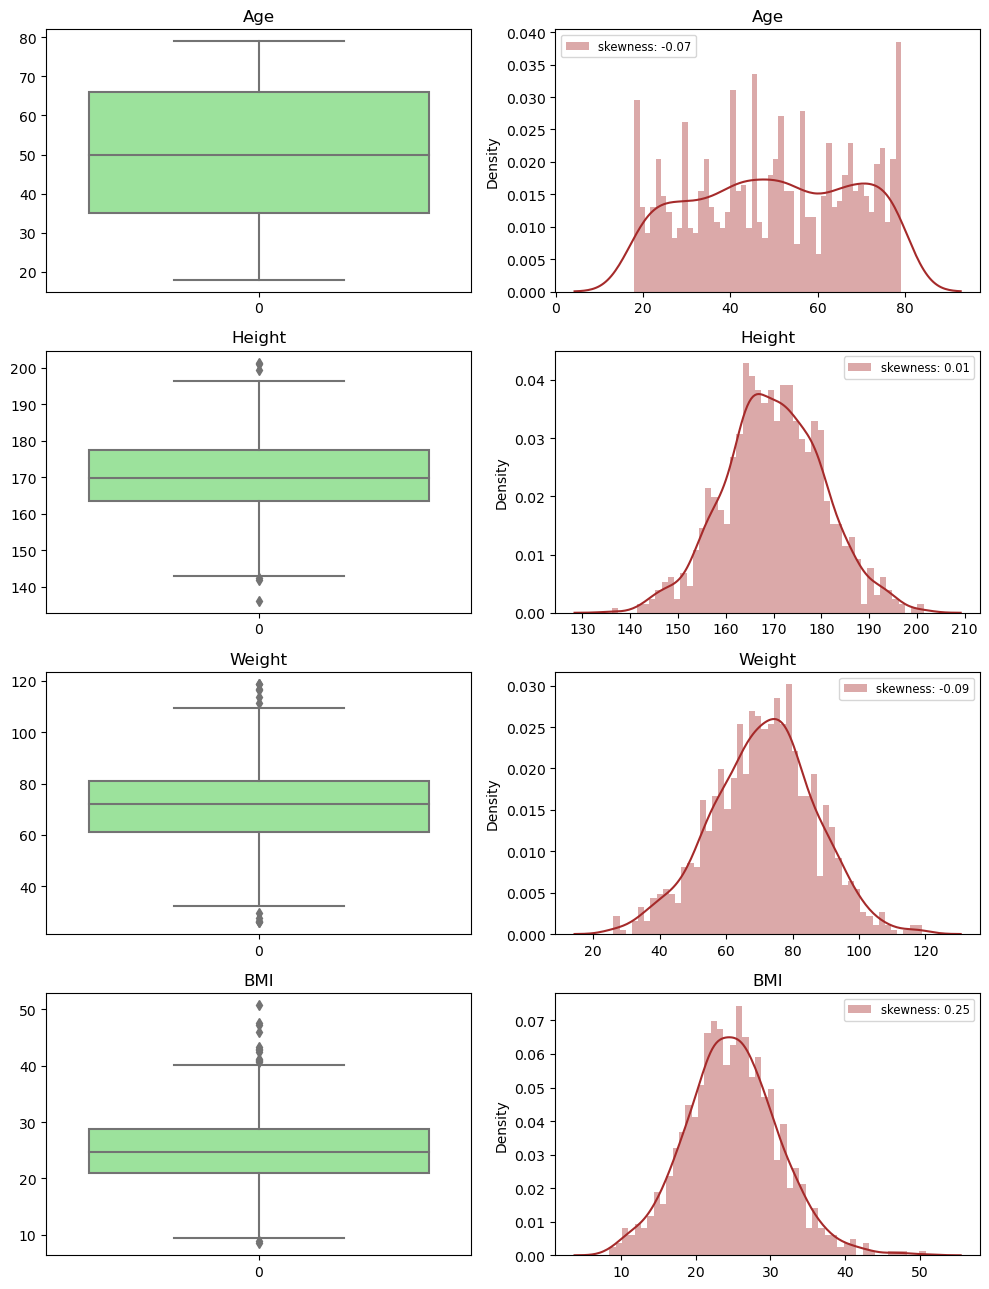

In [3]:
num_cols = obesity_data.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 13))
axes = axes.flatten()

for i, col in enumerate(num_cols[:-1]):
    ax1 = axes[i * 2]
    ax2 = axes[i * 2 + 1]

    sns.boxplot(data=obesity_data[col], ax=ax1, color="lightgreen")
    ax1.set_title(col)

    sns.distplot(obesity_data[col], ax=ax2, color="brown", bins=50, label=f"skewness: {obesity_data[col].skew().round(2)}")
    ax2.set_title(col)
    ax2.set_xlabel("")
    ax2.legend(fontsize="small")

plt.tight_layout()
plt.show()

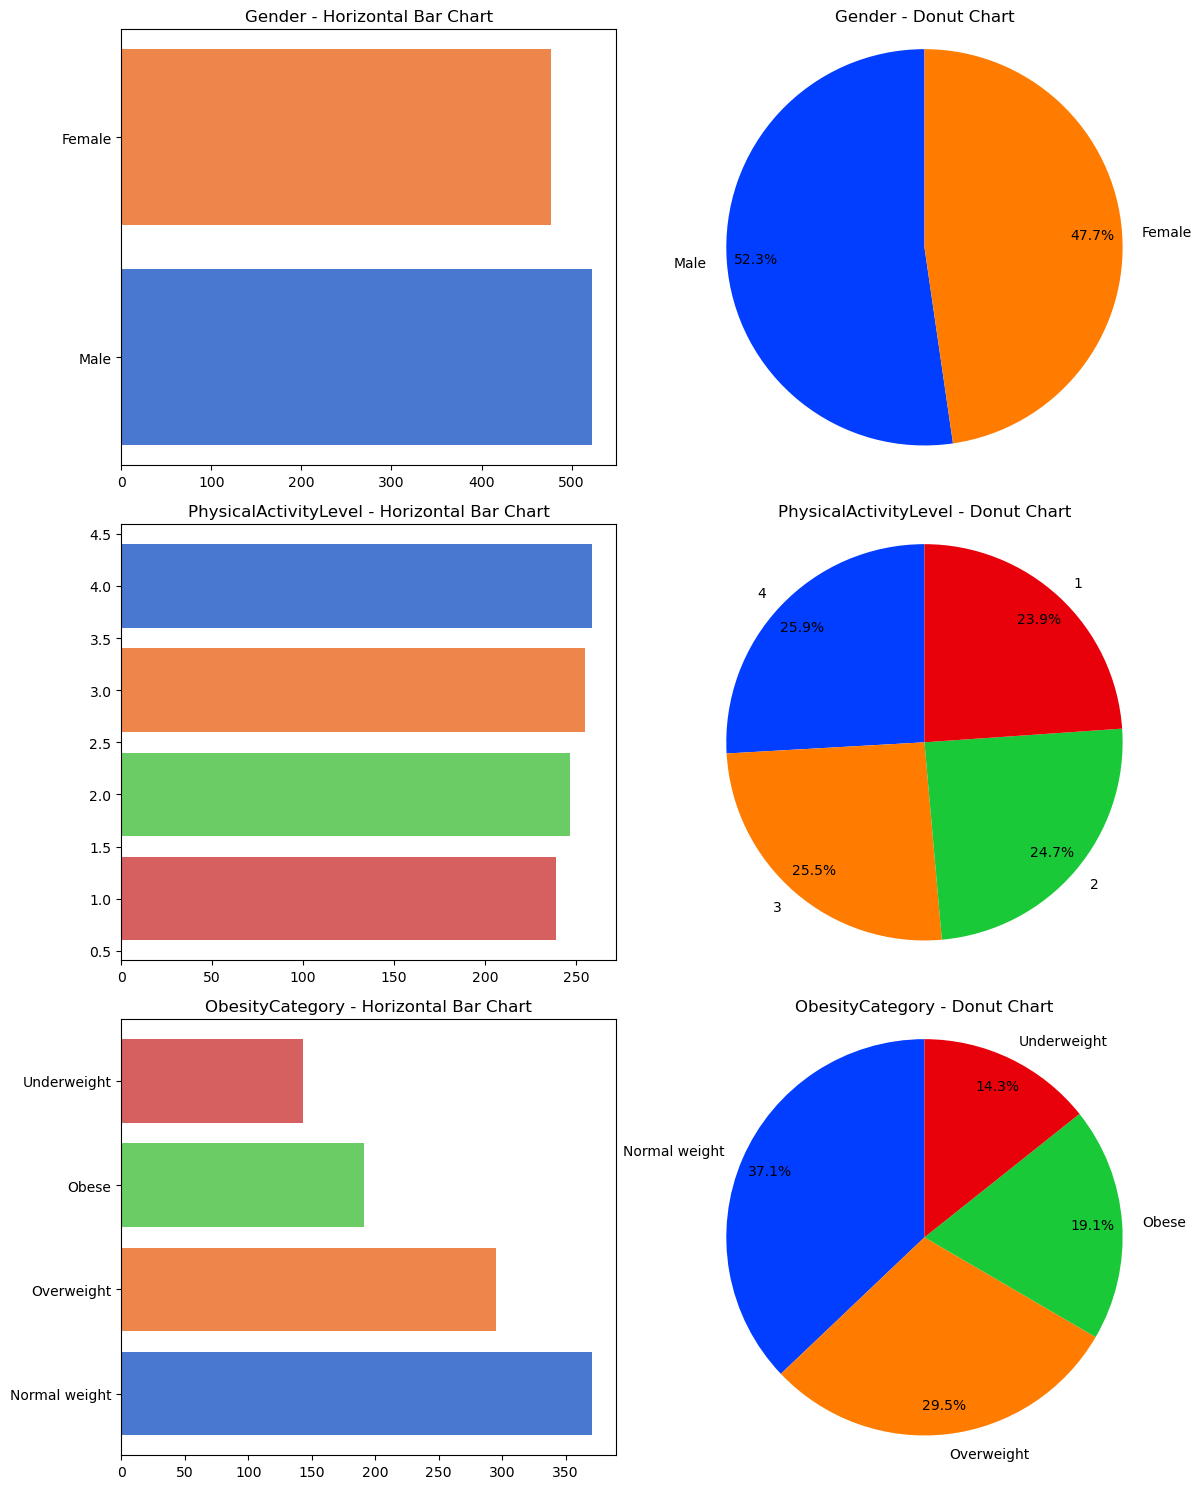

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten()

categorical_cols = ["Gender", "PhysicalActivityLevel", "ObesityCategory"]

for i, col in enumerate(categorical_cols):
    ax1, ax2 = axes[i * 2], axes[i * 2 + 1]

    # Horizontal bar chart
    value_counts = obesity_data[col].value_counts()
    ax1.barh(value_counts.index, value_counts.values, color=sns.color_palette("muted"))
    ax1.set_title(f"{col} - Horizontal Bar Chart")

    # Donut chart
    sizes = obesity_data[col].value_counts().values
    labels = obesity_data[col].value_counts().index
    colors = sns.color_palette("bright")[:len(sizes)]
    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax2.axis('equal')  
    ax2.set_title(f"{col} - Donut Chart")

plt.tight_layout()
plt.show()

In [5]:
obesity_data

,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight
...,...,...,...,...,...,...,...
995,18,Male,155.588674,64.103182,26.480345,4,Overweight
996,35,Female,165.076490,97.639771,35.830783,1,Obese
997,49,Female,156.570956,78.804284,32.146036,1,Obese
998,64,Male,164.192222,57.978115,21.505965,4,Normal weight


# Data Preprocessing

In [6]:
print('Number of rows with missing data: ', obesity_data.shape[0] - obesity_data.dropna().shape[0])

Number of rows with missing data:  0


In [7]:
def get_int_category(x):
    if x == 'Underweight':
        return 0
    elif x == 'Normal weight':
        return 1
    elif x == 'Overweight':
        return 2
    else:
        return 3

In [8]:
obesity_data['ObesityCategoryInt'] = obesity_data['ObesityCategory'].apply(lambda x: get_int_category(x))

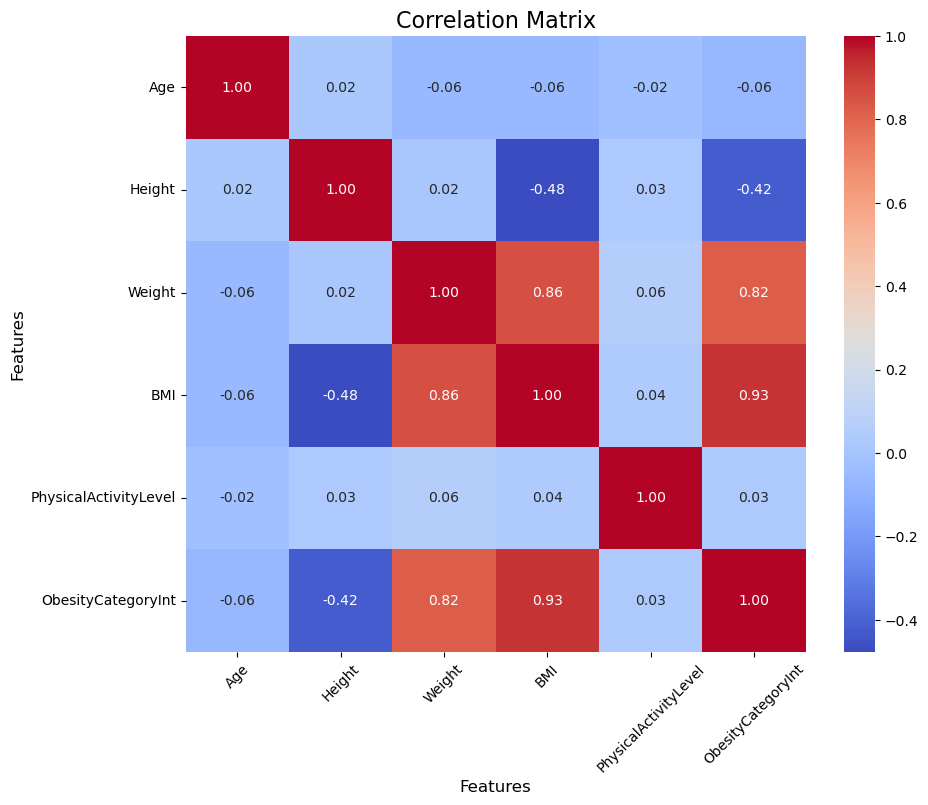

In [9]:
num_cols = obesity_data.select_dtypes(include=np.number).columns
corr_matrix = obesity_data[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

ax.set_title("Correlation Matrix", fontsize=16)
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Features", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)

plt.show()

<Axes: xlabel='BMI', ylabel='ObesityCategoryInt'>

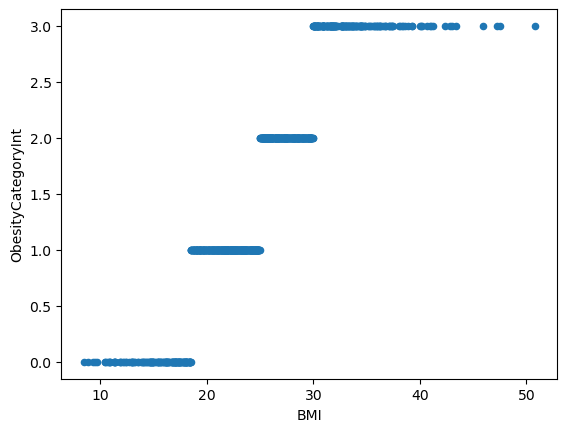

In [10]:
obesity_data.plot.scatter(x='BMI', y='ObesityCategoryInt')

# Attribute Selection

In [11]:
X_full = obesity_data.copy(deep=True)
y_full = X_full.pop('ObesityCategoryInt')
X_full['Gender'] = X_full['Gender'].apply(lambda g: 1 if g == 'Male' else 0)
X_full.drop(columns=['ObesityCategory'], inplace=True)

feature_selector = SequentialFeatureSelector(DecisionTreeClassifier(), direction='forward', tol=.001)
feature_selector.fit(X_full, y_full)
feature_selector.feature_names_in_[feature_selector.get_support()]

array(['BMI'], dtype=object)

In [12]:
feature_selector = SequentialFeatureSelector(DecisionTreeClassifier(), direction='backward', tol=-.001)
feature_selector.fit(X_full, y_full)
feature_selector.feature_names_in_[feature_selector.get_support()]

array(['BMI'], dtype=object)

# Model

<h5>Separating 20% of test data for later use. This is done not to overfit the model for test data</h5>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(obesity_data[['BMI']], 
                                                    obesity_data['ObesityCategoryInt'], 
                                                    test_size=0.2, 
                                                    stratify=obesity_data['ObesityCategoryInt'], 
                                                    random_state=121)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_scaler_decision_tree = Pipeline([('scaler',  StandardScaler()),
                               ('decision_tree', DecisionTreeClassifier(random_state=42, splitter='best'))])


param_grid = [{
    'decision_tree__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}]

In [63]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [16]:
model_accuracies = []

In [18]:
cross_validation = GridSearchCV(pipe_scaler_decision_tree, param_grid, cv=StratifiedKFold(n_splits=5))
cross_validation.fit(X_train, y_train)
print(cross_validation.cv_results_)
accuracy_score = cross_validation.best_estimator_.score(X_test, y_test)
model_accuracies.append({"Model": "DecisionTreeClassifier", "Accuracy": accuracy_score})

{'mean_fit_time': array([0.0033885 , 0.00277615, 0.00239282, 0.00278139, 0.00338731,
       0.00299702, 0.00302496, 0.00398264, 0.00270324]), 'std_fit_time': array([0.00135182, 0.00075298, 0.00048599, 0.00039644, 0.00048859,
       0.00064272, 0.00095152, 0.00100014, 0.00089056]), 'mean_score_time': array([0.00140557, 0.00111637, 0.0009973 , 0.00120797, 0.00163159,
       0.00118918, 0.00167522, 0.00127864, 0.00139661]), 'std_score_time': array([4.97171413e-04, 2.46083577e-04, 2.97429447e-05, 3.92852722e-04,
       5.19770014e-04, 3.82808227e-04, 5.66902362e-04, 4.03788679e-04,
       4.91398990e-04]), 'param_decision_tree__max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'decision_tree__max_depth': 2}, {'decision_tree__max_depth': 3}, {'decision_tree__max_depth': 4}, {'decision_tree__max_depth': 5}, {'decision_tr

In [20]:
pipe_scaler_decision_tree = Pipeline([('scaler',  StandardScaler()),
                               ('random_forest_classifier', RandomForestClassifier(random_state=42))])


param_grid = [{
    'random_forest_classifier__max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'random_forest_classifier__n_estimators': [2, 10, 50, 100, 250, 500, 1000]
}]

cross_validation = GridSearchCV(pipe_scaler_decision_tree, param_grid, cv=StratifiedKFold(n_splits=5))
cross_validation.fit(X_train, y_train)
print(cross_validation.cv_results_)
accuracy_score = cross_validation.best_estimator_.score(X_test, y_test)
model_accuracies.append({"Model": "RandomForestClassifier", "Accuracy": accuracy_score})

{'mean_fit_time': array([0.12350831, 0.12107549, 0.12058611, 0.12320986, 0.12768998,
       0.12693276, 0.12452893, 0.12371478, 0.11809392]), 'std_fit_time': array([0.00827269, 0.00507176, 0.00571768, 0.00861838, 0.00819476,
       0.00208746, 0.00527071, 0.00641983, 0.0058801 ]), 'mean_score_time': array([0.00959816, 0.00819154, 0.00860567, 0.00965834, 0.01051087,
       0.01068125, 0.0105485 , 0.01009607, 0.01128545]), 'std_score_time': array([0.00103932, 0.00026921, 0.00082296, 0.0010879 , 0.00134403,
       0.00185148, 0.00118627, 0.00132512, 0.00173028]), 'param_random_forest_classifier__max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'random_forest_classifier__max_depth': 2}, {'random_forest_classifier__max_depth': 3}, {'random_forest_classifier__max_depth': 4}, {'random_forest_classifier__max_depth': 5}, {

In [23]:
pipe_scaler_decision_tree = Pipeline([('scaler',  StandardScaler()),
                               ('knn_classifier', KNeighborsClassifier())])


param_grid = [{
    'knn_classifier__n_neighbors': [1,10, 20],
    'knn_classifier__leaf_size': [20,40],
    'knn_classifier__p': [1,2],
    'knn_classifier__weights': ['uniform', 'distance'],
    'knn_classifier__metric': ['minkowski', 'chebyshev']
}]

cross_validation = GridSearchCV(pipe_scaler_decision_tree, param_grid, cv=StratifiedKFold(n_splits=5))
cross_validation.fit(X_train, y_train)
print(cross_validation.cv_results_)
accuracy_score = cross_validation.best_estimator_.score(X_test, y_test)
model_accuracies.append({"Model": "KNeighborsClassifier", "Accuracy": accuracy_score})

{'mean_fit_time': array([0.00259199, 0.00279889, 0.00310121, 0.00286508, 0.00278029,
       0.0025064 , 0.00238357, 0.00198112, 0.00324426, 0.00360293,
       0.00244927, 0.00217013, 0.00308523, 0.00251255, 0.00306277,
       0.0025866 , 0.00325141, 0.00290613, 0.00312858, 0.00275149,
       0.00238681, 0.00241871, 0.00252948, 0.00295911, 0.0035059 ,
       0.00271916, 0.00366721, 0.00320964, 0.00290337, 0.00266733,
       0.00231223, 0.00320845, 0.00368447, 0.00269175, 0.0040626 ,
       0.00250111, 0.00244155, 0.00219393, 0.0019917 , 0.00230074,
       0.00239697, 0.0027782 , 0.00226293, 0.0023778 , 0.00299325,
       0.00260868, 0.00278182, 0.00282254]), 'std_fit_time': array([7.96629345e-04, 9.90977554e-04, 1.02109104e-03, 7.80008410e-04,
       7.28917736e-04, 4.47877245e-04, 4.95257557e-04, 3.79241755e-05,
       7.91244414e-04, 1.03496370e-03, 4.66132944e-04, 5.23377199e-04,
       5.96248680e-04, 4.69418334e-04, 2.61726069e-04, 6.36512417e-04,
       1.12361124e-03, 9.78935600e

                    Model  Accuracy
0  DecisionTreeClassifier       1.0
1  RandomForestClassifier       1.0
2    KNeighborsClassifier       1.0


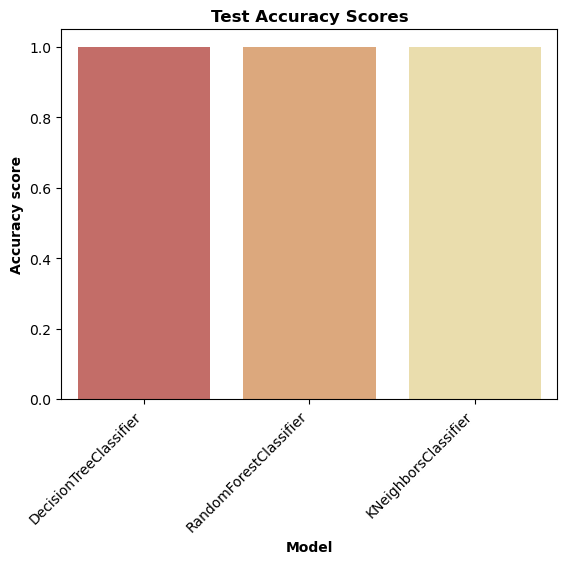

In [24]:
model_accuracies = pd.DataFrame(model_accuracies)
print(model_accuracies)
sns.set_palette("Spectral", n_colors=6, desat=0.8)

score_plot = sns.barplot(data=model_accuracies, y="Accuracy", x="Model")

# rotate the ticks 45 degrees for the sake of redability
score_plot.set_xticklabels(score_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title("Test Accuracy Scores",
          fontweight="bold")
ax.bar_label(score_plot.containers[0], fontweight="bold")
plt.xlabel("Model", fontweight="bold")
plt.ylabel("Accuracy score", fontweight="bold")

plt.show()